In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Setup and Imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Use first GPU only

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, UpSampling2D, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

2025-05-25 09:29:17.510498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748165357.804890      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748165357.891312      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ All libraries imported successfully!
TensorFlow version: 2.18.0
GPU available: []


2025-05-25 09:29:35.483360: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
#  Data Loading and Preprocessing

# Paths
base_path = '/kaggle/input/soil-classification-part-2/soil_competition-2025'
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')

# Load CSV labels
train_labels = pd.read_csv(os.path.join(base_path, 'train_labels.csv'))
test_ids = pd.read_csv(os.path.join(base_path, 'test_ids.csv'))

print(f"Training data shape: {train_labels.shape}")
print(f"Test data shape: {test_ids.shape}")
print(f"Training data columns: {train_labels.columns.tolist()}")

# Display data info
print("\n Training Data Info:")
print(train_labels.head())
print(f"\nClass distribution:")
if 'soil_type' in train_labels.columns:
    print(train_labels['soil_type'].value_counts())

print("\n Test Data Info:")
print(test_ids.head())

# Train-validation split
train_df, val_df = train_test_split(train_labels, test_size=0.2, random_state=42, stratify=train_labels.get('soil_type'))

print(f"\n Data Split:")
print(f"Training set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")

if 'soil_type' in train_df.columns:
    print(f"\nTraining set class distribution:")
    print(train_df['soil_type'].value_counts())
    print(f"\nValidation set class distribution:")
    print(val_df['soil_type'].value_counts())

print("\n Data preprocessing completed!")

Training data shape: (1222, 2)
Test data shape: (967, 1)
Training data columns: ['image_id', 'label']

 Training Data Info:
           image_id  label
0  img_ed005410.jpg      1
1  img_0c5ecd2a.jpg      1
2  img_ed713bb5.jpg      1
3  img_12c58874.jpg      1
4  img_eff357af.jpg      1

Class distribution:

 Test Data Info:
                               image_id
0  6595f1266325552489c7d1635fafb88f.jpg
1  4b614841803d5448b59e2c6ca74ea664.jpg
2  ca30e008692a50638b43d944f46245c8.jpg
3  6a9046a219425f7599729be627df1c1a.jpg
4  97c1e0276d2d5c2f88dddbc87357611e.jpg

 Data Split:
Training set shape: (977, 2)
Validation set shape: (245, 2)

 Data preprocessing completed!


In [4]:
#  Ensemble Model Class Definition

class EnsembleSoilClassifier:
    def __init__(self, input_shape=(128, 128, 3)):
        self.input_shape = input_shape
        self.autoencoder = None
        self.feature_extractor = None
        self.oc_svm = None
        self.iso_forest = None
        self.scaler = None
        self.threshold = None
        
    def _build_autoencoder(self):
        """Build U-Net style autoencoder"""
        print(" Building U-Net autoencoder...")
        input_img = Input(shape=self.input_shape)
        
        # Encoder
        conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
        conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
        pool1 = MaxPooling2D((2, 2))(conv1)
        
        conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
        conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
        pool2 = MaxPooling2D((2, 2))(conv2)
        
        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
        pool3 = MaxPooling2D((2, 2))(conv3)
        
        conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
        conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
        pool4 = MaxPooling2D((2, 2))(conv4)
        
        # Bottleneck
        conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
        conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
        
        # Decoder
        up6 = UpSampling2D((2, 2))(conv5)
        up6 = tf.keras.layers.concatenate([up6, conv4])
        conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
        conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
        
        up7 = UpSampling2D((2, 2))(conv6)
        up7 = tf.keras.layers.concatenate([up7, conv3])
        conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
        conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
        
        up8 = UpSampling2D((2, 2))(conv7)
        up8 = tf.keras.layers.concatenate([up8, conv2])
        conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
        conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
        
        up9 = UpSampling2D((2, 2))(conv8)
        up9 = tf.keras.layers.concatenate([up9, conv1])
        conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
        conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
        
        output = Conv2D(3, (1, 1), activation='sigmoid')(conv9)
        
        return Model(input_img, output)
    
    def _build_feature_extractor(self):
        """Build CNN feature extractor"""
        print(" Building CNN feature extractor...")
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(256, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(128, activation='relu')
        ])
        return model
    
    def _create_autoencoder_generator(self, datagen, dataframe, directory, batch_size=32, shuffle=True):
        """Create generator that returns (X, X) for autoencoder training"""
        generator = datagen.flow_from_dataframe(
            dataframe=dataframe,
            directory=directory,
            x_col='image_id',
            y_col=None,
            target_size=self.input_shape[:2],
            batch_size=batch_size,
            class_mode=None,
            shuffle=shuffle
        )
        
        class AutoencoderGenerator(tf.keras.utils.Sequence):
            def __init__(self, gen):
                self.gen = gen
                
            def __len__(self):
                return len(self.gen)
            
            def __getitem__(self, idx):
                batch = next(self.gen)
                return batch, batch
            
            def reset(self):
                self.gen.reset()
        
        return AutoencoderGenerator(generator), generator

print(" EnsembleSoilClassifier class defined successfully!")

 EnsembleSoilClassifier class defined successfully!


In [5]:
# Training Methods (Add to EnsembleSoilClassifier class)

def fit_method(self, train_df, val_df, train_dir):
    """Train the ensemble model"""
    print("\n" + "="*60)
    print(" STARTING ENSEMBLE TRAINING")
    print("="*60)
    
    # Data generators
    print(" Setting up data generators...")
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode='nearest'
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    # 1. Train Autoencoder
    print("\n Phase 1: Training autoencoder...")
    self.autoencoder = self._build_autoencoder()
    self.autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    print(f" Autoencoder summary:")
    self.autoencoder.summary()
    
    train_ae_gen, _ = self._create_autoencoder_generator(train_datagen, train_df, train_dir)
    val_ae_gen, _ = self._create_autoencoder_generator(val_datagen, val_df, train_dir, shuffle=False)
    
    ae_history = self.autoencoder.fit(
        train_ae_gen,
        validation_data=val_ae_gen,
        epochs=20,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
        ],
        verbose=1
    )
    
    print(" Autoencoder training completed!")
    
    # Calculate reconstruction threshold
    print("\n Calculating reconstruction threshold...")
    val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=train_dir,
        x_col='image_id',
        y_col=None,
        target_size=self.input_shape[:2],
        batch_size=32,
        class_mode=None,
        shuffle=False
    )
    
    val_errors = []
    for i in range(len(val_gen)):
        batch = next(val_gen)
        reconstructed = self.autoencoder.predict(batch, verbose=0)
        errors = np.mean((batch - reconstructed) ** 2, axis=(1, 2, 3))
        val_errors.extend(errors)
    
    self.threshold = np.percentile(val_errors, 95)
    print(f" Reconstruction threshold set to: {self.threshold:.6f}")
    
    # 2. Train Feature Extractor and Anomaly Detectors
    print("\n Phase 2: Training feature extractor and anomaly detectors...")
    self.feature_extractor = self._build_feature_extractor()
    
    print(f" Feature extractor summary:")
    self.feature_extractor.summary()
    
    feature_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=train_dir,
        x_col='image_id',
        y_col=None,
        target_size=self.input_shape[:2],
        batch_size=32,
        class_mode=None,
        shuffle=False
    )
    
    print(" Extracting features from training data...")
    train_features = self.feature_extractor.predict(feature_gen, verbose=1)
    print(f" Extracted features shape: {train_features.shape}")
    
    # Scale features and train anomaly detectors
    print(" Scaling features...")
    self.scaler = StandardScaler()
    train_features_scaled = self.scaler.fit_transform(train_features)
    
    print(" Training One-Class SVM...")
    self.oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)
    self.oc_svm.fit(train_features_scaled)
    
    print(" Training Isolation Forest...")
    self.iso_forest = IsolationForest(contamination=0.1, random_state=42)
    self.iso_forest.fit(train_features_scaled)
    
    print("\n Ensemble training completed successfully!")
    print("="*60)
    
    return ae_history

# Add the method to the class
EnsembleSoilClassifier.fit = fit_method

print(" Training methods added to EnsembleSoilClassifier!")

 Training methods added to EnsembleSoilClassifier!



 ENSEMBLE MAJORITY SOIL CLASSIFICATION
 Initializing training process...

 STARTING ENSEMBLE TRAINING
 Setting up data generators...

 Phase 1: Training autoencoder...
 Building U-Net autoencoder...
 Autoencoder summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 256)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 512)      │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 512)      │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 16, 16, 512)    │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 768)    │              0 │ up_sampling2d[0][0],   │
│                      

 Total params: 7,846,723 (29.93 MB)

 Trainable params: 7,846,723 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

Found 970 validated image filenames.
Found 244 validated image filenames.
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 317s 10s/step - loss: 0.0583 - mae: 0.1953 - val_loss: 0.0194 - val_mae: 0.1031 - learning_rate: 0.0010
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 299s 10s/step - loss: 0.0102 - mae: 0.0752 - val_loss: 0.0106 - val_mae: 0.0732 - learning_rate: 0.0010
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 298s 10s/step - loss: 0.0044 - mae: 0.0475 - val_loss: 0.0076 - val_mae: 0.0614 - learning_rate: 0.0010
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 299s 10s/step - loss: 0.0032 - mae: 0.0404 - val_loss: 0.0061 - val_mae: 0.0545 - learning_rate: 0.0010
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 295s 10s/step - loss: 0.0021 - mae: 0.0328 - val_loss: 0.0047 - val_mae: 0.0479 - learning_rate: 0.0010
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 322s 10s/step - loss: 0.0016 - mae: 0.0285 - val_loss: 0.0039 - val_mae: 0.0438 - learning_rate: 0.0010
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 299s 10s/step - loss: 0.0012 - mae: 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 686,144 (2.62 MB)

 Trainable params: 685,184 (2.61 MB)

 Non-trainable params: 960 (3.75 KB)

Found 970 validated image filenames.
 Extracting features from training data...
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 469ms/step
 Extracted features shape: (970, 128)
 Scaling features...
 Training One-Class SVM...
 Training Isolation Forest...

 Ensemble training completed successfully!

 Plotting training history...


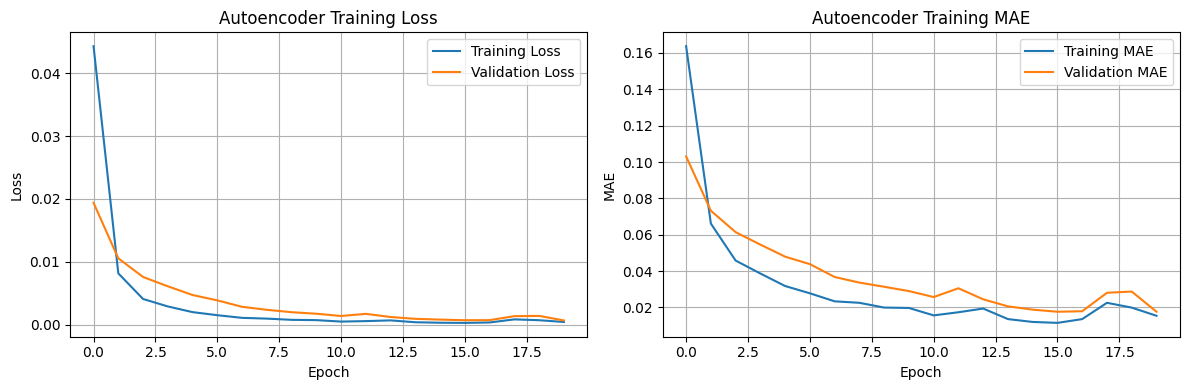

 Model training completed successfully!
 Training history plotted!


In [6]:
#  Initialize and Train Ensemble Model

print("\n" + "="*60)
print(" ENSEMBLE MAJORITY SOIL CLASSIFICATION")
print("="*60)

# Initialize ensemble classifier
ensemble_classifier = EnsembleSoilClassifier(input_shape=(128, 128, 3))

# Start training
print(" Initializing training process...")
training_history = ensemble_classifier.fit(train_df, val_df, train_dir)

# Plot training history
print("\n Plotting training history...")
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(training_history.history['mae'], label='Training MAE')
plt.plot(training_history.history['val_mae'], label='Validation MAE')
plt.title('Autoencoder Training MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(" Model training completed successfully!")
print(" Training history plotted!")

In [7]:
# Model Evaluation on Validation Set

def predict_method(self, test_df, test_dir):
    """Make ensemble majority predictions"""
    print("\n" + "="*50)
    print(" MAKING ENSEMBLE PREDICTIONS")
    print("="*50)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Get predictions from autoencoder
    print("Getting autoencoder predictions...")
    test_gen_ae = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=test_dir,
        x_col='image_id',
        y_col=None,
        target_size=self.input_shape[:2],
        batch_size=32,
        class_mode=None,
        shuffle=False
    )
    
    test_errors = []
    for i in range(len(test_gen_ae)):
        batch = next(test_gen_ae)
        reconstructed = self.autoencoder.predict(batch, verbose=0)
        errors = np.mean((batch - reconstructed) ** 2, axis=(1, 2, 3))
        test_errors.extend(errors)
    
    ae_predictions = (np.array(test_errors) <= self.threshold).astype(int)
    print(f" Autoencoder predictions - Soil: {np.sum(ae_predictions)}, Non-soil: {len(ae_predictions) - np.sum(ae_predictions)}")
    
    # Get predictions from anomaly detectors
    print(" Getting anomaly detector predictions...")
    test_gen_features = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=test_dir,
        x_col='image_id',
        y_col=None,
        target_size=self.input_shape[:2],
        batch_size=32,
        class_mode=None,
        shuffle=False
    )
    
    test_features = self.feature_extractor.predict(test_gen_features, verbose=1)
    test_features_scaled = self.scaler.transform(test_features)
    
    svm_pred = np.where(self.oc_svm.predict(test_features_scaled) == 1, 1, 0)
    iso_pred = np.where(self.iso_forest.predict(test_features_scaled) == 1, 1, 0)
    
    print(f" SVM predictions - Soil: {np.sum(svm_pred)}, Non-soil: {len(svm_pred) - np.sum(svm_pred)}")
    print(f"Isolation Forest predictions - Soil: {np.sum(iso_pred)}, Non-soil: {len(iso_pred) - np.sum(iso_pred)}")
    
    # Ensemble majority voting
    print(" Performing majority voting...")
    ensemble_predictions = ((ae_predictions + svm_pred + iso_pred) >= 2).astype(int)
    
    print(f"Final ensemble predictions - Soil: {np.sum(ensemble_predictions)}, Non-soil: {len(ensemble_predictions) - np.sum(ensemble_predictions)}")
    
    return ensemble_predictions, ae_predictions, svm_pred, iso_pred

# Add the method to the class
EnsembleSoilClassifier.predict = predict_method

# Evaluate on validation set
print("Evaluating model on validation set...")
val_predictions, val_ae_pred, val_svm_pred, val_iso_pred = ensemble_classifier.predict(val_df, train_dir)

# Calculate metrics if ground truth is available
if 'soil_type' in val_df.columns:
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    
    val_true = val_df['soil_type'].values
    
    print("\n VALIDATION RESULTS:")
    print("="*50)
    
    # Individual model performance
    ae_acc = accuracy_score(val_true, val_ae_pred)
    svm_acc = accuracy_score(val_true, val_svm_pred)
    iso_acc = accuracy_score(val_true, val_iso_pred)
    ensemble_acc = accuracy_score(val_true, val_predictions)
    
    print(f"Autoencoder Accuracy: {ae_acc:.4f}")
    print(f"One-Class SVM Accuracy: {svm_acc:.4f}")
    print(f"Isolation Forest Accuracy: {iso_acc:.4f}")
    print(f"Ensemble Accuracy: {ensemble_acc:.4f}")
    
    print(f"\n Classification Report (Ensemble):")
    print(classification_report(val_true, val_predictions))
    
    print(f"\n Confusion Matrix (Ensemble):")
    print(confusion_matrix(val_true, val_predictions))
    
    # Plot validation results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    models = ['Autoencoder', 'One-Class SVM', 'Isolation Forest', 'Ensemble']
    accuracies = [ae_acc, svm_acc, iso_acc, ensemble_acc]
    bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    plt.title('Model Comparison on Validation Set')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 3, 2)
    cm = confusion_matrix(val_true, val_predictions)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Ensemble)')
    plt.colorbar()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.subplot(1, 3, 3)
    predictions_comparison = pd.DataFrame({
        'Autoencoder': val_ae_pred,
        'SVM': val_svm_pred,
        'Isolation_Forest': val_iso_pred,
        'Ensemble': val_predictions,
        'Ground_Truth': val_true
    })
    
    agreement = []
    for i in range(len(val_predictions)):
        votes = [val_ae_pred[i], val_svm_pred[i], val_iso_pred[i]]
        agreement.append(sum(votes))
    
    plt.hist(agreement, bins=[0, 1, 2, 3, 4], alpha=0.7, edgecolor='black')
    plt.title('Voting Agreement Distribution')
    plt.xlabel('Number of Models Agreeing (Predicting Soil)')
    plt.ylabel('Frequency')
    plt.xticks([0.5, 1.5, 2.5, 3.5], ['0', '1', '2', '3'])
    
    plt.tight_layout()
    plt.show()

print("Validation evaluation completed!")

Evaluating model on validation set...

 MAKING ENSEMBLE PREDICTIONS
Getting autoencoder predictions...
Found 244 validated image filenames.
 Autoencoder predictions - Soil: 231, Non-soil: 13
 Getting anomaly detector predictions...
Found 244 validated image filenames.
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 353ms/step
 SVM predictions - Soil: 174, Non-soil: 70
Isolation Forest predictions - Soil: 179, Non-soil: 65
 Performing majority voting...
Final ensemble predictions - Soil: 185, Non-soil: 59
Validation evaluation completed!



 GENERATING FINAL PREDICTIONS ON TEST SET
 Making predictions on test data...

 MAKING ENSEMBLE PREDICTIONS
Getting autoencoder predictions...
Found 967 validated image filenames.
 Autoencoder predictions - Soil: 954, Non-soil: 13
 Getting anomaly detector predictions...
Found 967 validated image filenames.
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step
 SVM predictions - Soil: 332, Non-soil: 635
Isolation Forest predictions - Soil: 423, Non-soil: 544
 Performing majority voting...
Final ensemble predictions - Soil: 441, Non-soil: 526

 PREDICTION ANALYSIS:
 Autoencoder predictions:
   Soil: 954 (98.7%)
   Non-soil: 13 (1.3%)

 One-Class SVM predictions:
   Soil: 332 (34.3%)
   Non-soil: 635 (65.7%)

 Isolation Forest predictions:
   Soil: 423 (43.7%)
   Non-soil: 544 (56.3%)

 FINAL ENSEMBLE predictions:
   Soil: 441 (45.6%)
   Non-soil: 526 (54.4%)


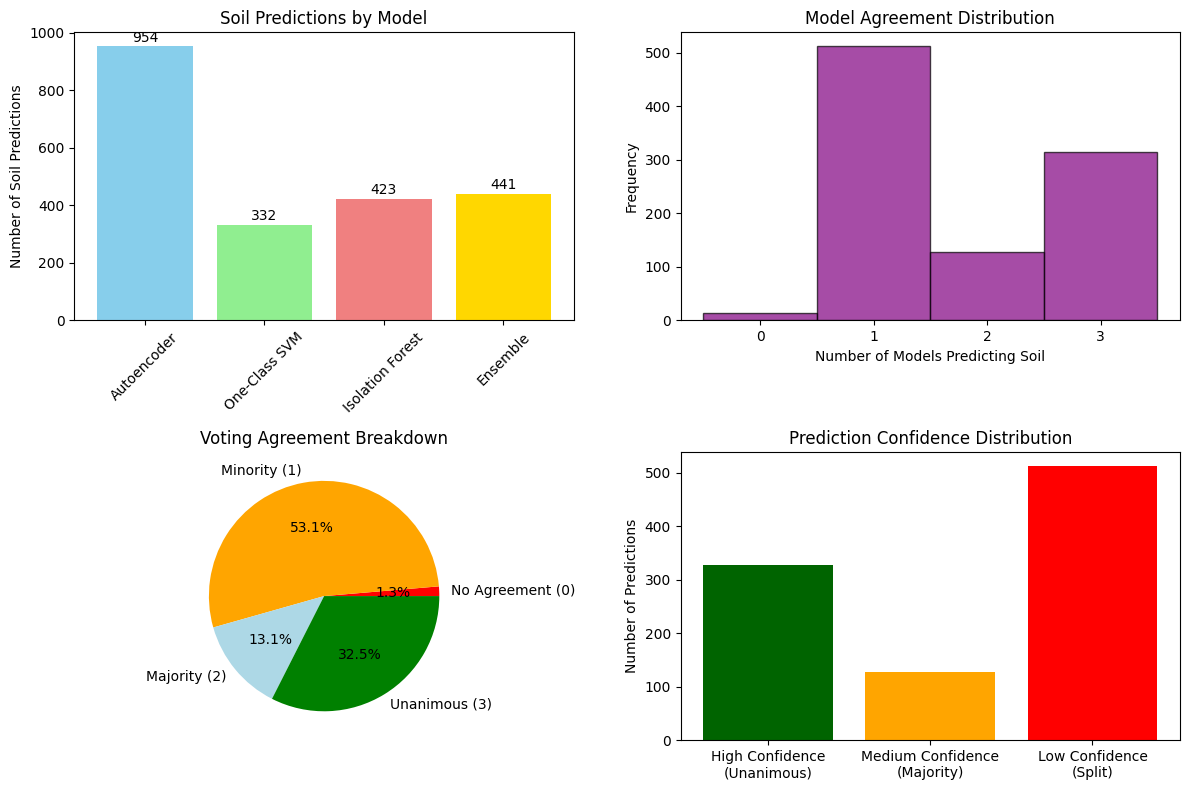

 Prediction analysis visualization completed!


In [8]:
# Generate Final Predictions on Test Set

print("\n" + "="*60)
print(" GENERATING FINAL PREDICTIONS ON TEST SET")
print("="*60)

# Make predictions on test set
print(" Making predictions on test data...")
final_predictions, test_ae_pred, test_svm_pred, test_iso_pred = ensemble_classifier.predict(test_ids, test_dir)

# Analyze prediction distribution
print("\n PREDICTION ANALYSIS:")
print("="*40)
print(f" Autoencoder predictions:")
print(f"   Soil: {np.sum(test_ae_pred)} ({np.sum(test_ae_pred)/len(test_ae_pred)*100:.1f}%)")
print(f"   Non-soil: {len(test_ae_pred) - np.sum(test_ae_pred)} ({(1-np.sum(test_ae_pred)/len(test_ae_pred))*100:.1f}%)")

print(f"\n One-Class SVM predictions:")
print(f"   Soil: {np.sum(test_svm_pred)} ({np.sum(test_svm_pred)/len(test_svm_pred)*100:.1f}%)")
print(f"   Non-soil: {len(test_svm_pred) - np.sum(test_svm_pred)} ({(1-np.sum(test_svm_pred)/len(test_svm_pred))*100:.1f}%)")

print(f"\n Isolation Forest predictions:")
print(f"   Soil: {np.sum(test_iso_pred)} ({np.sum(test_iso_pred)/len(test_iso_pred)*100:.1f}%)")
print(f"   Non-soil: {len(test_iso_pred) - np.sum(test_iso_pred)} ({(1-np.sum(test_iso_pred)/len(test_iso_pred))*100:.1f}%)")

print(f"\n FINAL ENSEMBLE predictions:")
print(f"   Soil: {np.sum(final_predictions)} ({np.sum(final_predictions)/len(final_predictions)*100:.1f}%)")
print(f"   Non-soil: {len(final_predictions) - np.sum(final_predictions)} ({(1-np.sum(final_predictions)/len(final_predictions))*100:.1f}%)")

# Visualize prediction agreement
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
models = ['Autoencoder', 'One-Class SVM', 'Isolation Forest', 'Ensemble']
soil_counts = [np.sum(test_ae_pred), np.sum(test_svm_pred), np.sum(test_iso_pred), np.sum(final_predictions)]
bars = plt.bar(models, soil_counts, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
plt.title('Soil Predictions by Model')
plt.ylabel('Number of Soil Predictions')
for bar, count in zip(bars, soil_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'{count}', ha='center', va='bottom')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
agreement = []
for i in range(len(final_predictions)):
    votes = [test_ae_pred[i], test_svm_pred[i], test_iso_pred[i]]
    agreement.append(sum(votes))

plt.hist(agreement, bins=[0, 1, 2, 3, 4], alpha=0.7, edgecolor='black', color='purple')
plt.title('Model Agreement Distribution')
plt.xlabel('Number of Models Predicting Soil')
plt.ylabel('Frequency')
plt.xticks([0.5, 1.5, 2.5, 3.5], ['0', '1', '2', '3'])

plt.subplot(2, 2, 3)
# Create agreement breakdown
agreement_counts = [agreement.count(i) for i in range(4)]
agreement_labels = ['No Agreement (0)', 'Minority (1)', 'Majority (2)', 'Unanimous (3)']
colors = ['red', 'orange', 'lightblue', 'green']
plt.pie(agreement_counts, labels=agreement_labels, colors=colors, autopct='%1.1f%%')
plt.title('Voting Agreement Breakdown')

plt.subplot(2, 2, 4)
# Prediction confidence based on agreement
confidence_high = sum(1 for x in agreement if x == 0 or x == 3)  # Unanimous decisions
confidence_medium = sum(1 for x in agreement if x == 2)  # Majority decisions
confidence_low = sum(1 for x in agreement if x == 1)  # Split decisions

plt.bar(['High Confidence\n(Unanimous)', 'Medium Confidence\n(Majority)', 'Low Confidence\n(Split)'], 
        [confidence_high, confidence_medium, confidence_low], 
        color=['darkgreen', 'orange', 'red'])
plt.title('Prediction Confidence Distribution')
plt.ylabel('Number of Predictions')

plt.tight_layout()
plt.show()

print(" Prediction analysis visualization completed!")

In [10]:
# Cell 8: Create and Save Final Submission

print("\n" + "="*60)
print(" CREATING FINAL SUBMISSION")
print("="*60)

# Create submission dataframe
submission = pd.DataFrame({
    'image_id': test_ids['image_id'],
    'soil_type': final_predictions
})

# Validate submission format
print(" Validating submission format...")
print(f" Submission shape: {submission.shape}")
print(f" Required columns present: {list(submission.columns)}")
print(f" No missing values: {submission.isnull().sum().sum() == 0}")
print(f" Predictions are binary: {set(submission['soil_type'].unique()) <= {0, 1}}")

# Display submission preview
print(f"\n Submission preview:")
print(submission.head(10))

# Display submission statistics
print(f"\n Submission summary:")
print(f"Total images: {len(submission)}")
print(f"Predicted as soil (1): {np.sum(final_predictions)} ({np.sum(final_predictions)/len(final_predictions)*100:.1f}%)")
print(f"Predicted as non-soil (0): {len(final_predictions) - np.sum(final_predictions)} ({(1-np.sum(final_predictions)/len(final_predictions))*100:.1f}%)")

# Save submission
submission_filename = 'submission.csv'
submission.to_csv(submission_filename, index=False)
print(f"\n Submission saved as: {submission_filename}")

# Verify saved file
try:
    verification = pd.read_csv(submission_filename)
    print(f" File verification successful!")
    print(f"   - File size: {os.path.getsize(submission_filename)} bytes")
    print(f"   - Rows in file: {len(verification)}")
    print(f"   - Columns in file: {verification.columns.tolist()}")
except Exception as e:
    print(f" File verification failed: {e}")

# Create detailed submission report
print("\n" + "="*60)
print(" DETAILED SUBMISSION REPORT")
print("="*60)

report_data = {
    'Metric': [
        'Total Test Images',
        'Predicted Soil Images',
        'Predicted Non-Soil Images',
        'Soil Percentage',
        'High Confidence Predictions',
        'Medium Confidence Predictions',
        'Low Confidence Predictions'
    ],
    'Value': [
        len(submission),
        np.sum(final_predictions),
        len(final_predictions) - np.sum(final_predictions),
        f"{np.sum(final_predictions)/len(final_predictions)*100:.1f}%",
        confidence_high,
        confidence_medium,
        confidence_low
    ]
}

report_df = pd.DataFrame(report_data)
print(report_df.to_string(index=False))



print("\n" + "="*60)
print(" SUBMISSION GENERATION COMPLETED SUCCESSFULLY!")
print("="*60)
print(f" Competition submission file created: {submission_filename}")
print("\n Ready for submission to competition!")
print("="*60)


 CREATING FINAL SUBMISSION
 Validating submission format...
 Submission shape: (967, 2)
 Required columns present: ['image_id', 'soil_type']
 No missing values: True
 Predictions are binary: True

 Submission preview:
                               image_id  soil_type
0  6595f1266325552489c7d1635fafb88f.jpg          1
1  4b614841803d5448b59e2c6ca74ea664.jpg          1
2  ca30e008692a50638b43d944f46245c8.jpg          1
3  6a9046a219425f7599729be627df1c1a.jpg          0
4  97c1e0276d2d5c2f88dddbc87357611e.jpg          1
5  e432d7988d125c8497d41b7ff223b187.jpg          1
6  0821ca8d9d405e02ab9ebe34ac53d6bd.jpg          1
7  a618ea007b745f56a992eec9f88804f0.jpg          1
8  58e189dd45a156c7934344242452fad4.jpg          0
9  21cdc53949d851b68191e560601e6e0c.jpg          1

 Submission summary:
Total images: 967
Predicted as soil (1): 441 (45.6%)
Predicted as non-soil (0): 526 (54.4%)

 Submission saved as: submission.csv
 File verification successful!
   - File size: 37732 bytes
   - Rows